In [1]:
#!gdown --id "1vsfryu2rlbNUlXmE2gP8cLXly3zIQUPj&confirm=t"
#!gdown --id "1Ztft_-dTz9FXwiDgMqrHqWDvyd7_Ozfb&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1vsfryu2rlbNUlXmE2gP8cLXly3zIQUPj
To: /content/topics.txt
100% 71.0/71.0 [00:00<00:00, 217kB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ztft_-dTz9FXwiDgMqrHqWDvyd7_Ozfb
To: /content/develop.txt
100% 2.48M/2.48M [00:00<00:00, 80.2MB/s]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy: 0.3905882352941176
AUC: 0.7136
F1 Score: 0.5869
Classification Report:
              precision    recall  f1-score   support

         acq       0.94      0.86      0.90        78
        corn       0.00      0.00      0.00        25
       crude       0.95      0.43      0.59        87
       grain       0.97      0.48      0.65        62
    interest       0.90      0.30      0.44        61
    money-fx       0.85      0.60      0.71        88
        ship       0.91      0.23      0.37        43
       trade       0.83      0.30      0.44        67
       wheat       0.75      0.08      0.15        36

   micro avg       0.90      0.44      0.59       547
   macro avg       0.79      0.36      0.47       547
weighted avg       0.86      0.44      0.55       547
 samples avg       0.52      0.47      0.48       547



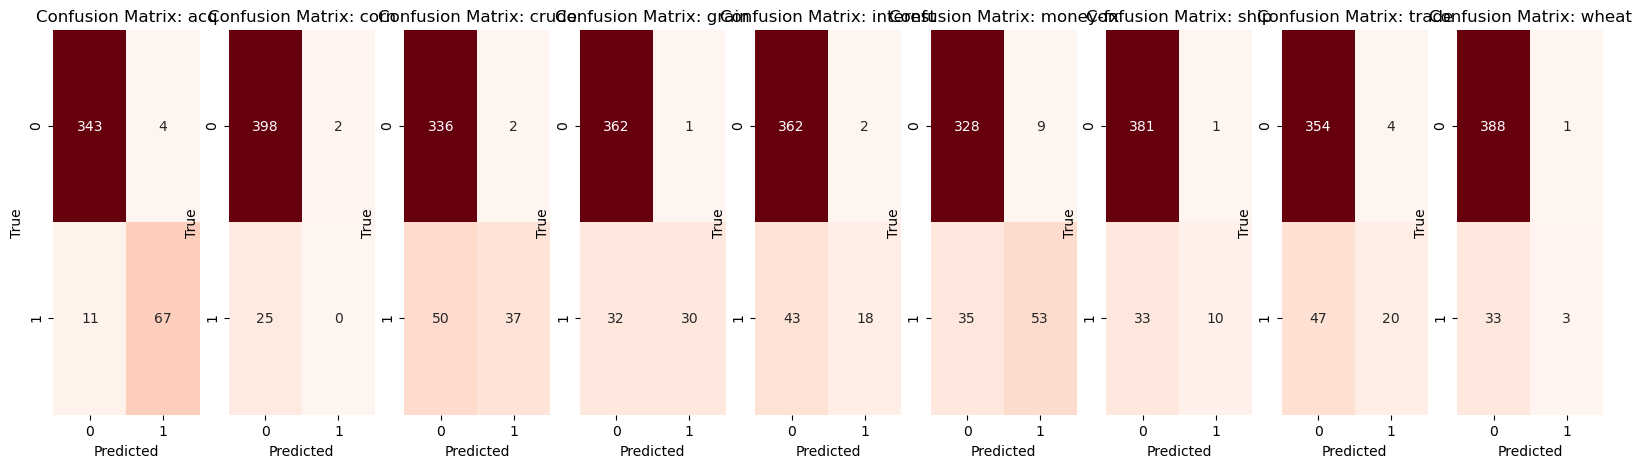

In [17]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(texts):
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(**encoded_inputs)
    return outputs.last_hidden_state[:, 0, :]

def plot_confusion_matrices(conf_matrices, labels):
    n_labels = len(labels)
    fig, axes = plt.subplots(1, n_labels, figsize=(20, 5))
    if n_labels == 1:
        axes = [axes]
    for i, (matrix, label) in enumerate(zip(conf_matrices, labels)):
        disp = sns.heatmap(matrix, annot=True, fmt='d', ax=axes[i], cmap='Reds', cbar=False)
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    plt.show()

if __name__ == '__main__':
    with open("develop.txt", "r") as f:
        raw_train_data = f.readlines()
    with open("topics.txt", "r") as f:
        topics = f.readlines()

    topics = topics[::2]
    topics = [i.strip() for i in topics]
    train_text_data = raw_train_data[2::4]
    train_topics = [i.strip(">\n").split()[2:] for i in raw_train_data[::4]]

    articles = train_text_data
    textual_labels = train_topics

    mlb = MultiLabelBinarizer()
    binary_labels = mlb.fit_transform(textual_labels)
    label_classes = mlb.classes_

    X_train, X_test, y_train, y_test = train_test_split(articles, binary_labels, test_size=0.2, random_state=42)

    batch_size = 8
    train_embeddings = []
    for i in range(0, len(X_train), batch_size):
        batch_texts = X_train[i:i+batch_size]
        batch_embeddings = get_bert_embeddings(batch_texts)
        train_embeddings.append(batch_embeddings)
    X_train_bert = torch.cat(train_embeddings, dim=0)

    test_embeddings = []
    for i in range(0, len(X_test), batch_size):
        batch_texts = X_test[i:i+batch_size]
        batch_embeddings = get_bert_embeddings(batch_texts)
        test_embeddings.append(batch_embeddings)
    X_test_bert = torch.cat(test_embeddings, dim=0)

    classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
    classifier.fit(X_train_bert.cpu().numpy(), y_train)

    y_pred = classifier.predict(X_test_bert.cpu().numpy())

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    auc = roc_auc_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    print(f'AUC: {auc:.4f}')
    print(f'F1 Score: {f1:.4f}')

    class_report = classification_report(y_test, y_pred, target_names=label_classes, zero_division=0)
    print("Classification Report:")
    print(class_report)

    conf_matrix = multilabel_confusion_matrix(y_test, y_pred)
    plot_confusion_matrices(conf_matrix, label_classes)


Accuracy: 0.6470588235294118
AUC: 0.8572
F1 Score: 0.8131
Classification Report:
              precision    recall  f1-score   support

         acq       0.95      0.88      0.91        78
        corn       0.86      0.24      0.38        25
       crude       0.93      0.79      0.86        87
       grain       0.92      0.90      0.91        62
    interest       0.92      0.56      0.69        61
    money-fx       0.92      0.78      0.85        88
        ship       0.94      0.72      0.82        43
       trade       0.96      0.73      0.83        67
       wheat       0.81      0.36      0.50        36

   micro avg       0.93      0.72      0.81       547
   macro avg       0.91      0.66      0.75       547
weighted avg       0.92      0.72      0.80       547
 samples avg       0.80      0.76      0.77       547



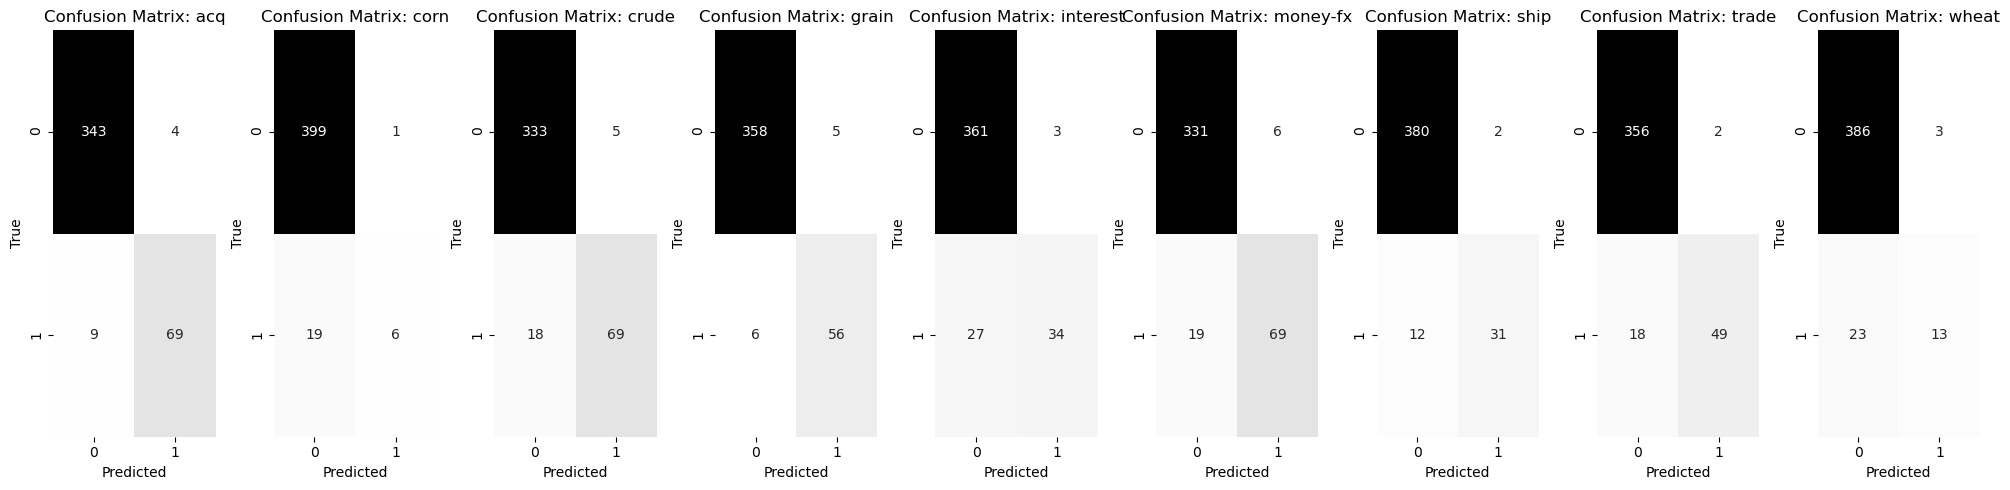

In [19]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(conf_matrices, labels):
    n_labels = len(labels)
    fig, axes = plt.subplots(1, n_labels, figsize=(20, 5))
    if n_labels == 1:
        axes = [axes]
    for i, (matrix, label) in enumerate(zip(conf_matrices, labels)):
        disp = sns.heatmap(matrix, annot=True, fmt='d', ax=axes[i], cmap='Greys', cbar=False)
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    with open("develop.txt", "r") as f:
        raw_train_data = f.readlines()
    with open("topics.txt", "r") as f:
        topics = f.readlines()

    topics = topics[::2]
    topics = [i.strip() for i in topics]
    train_text_data = raw_train_data[2::4]
    train_topics = [i.strip(">\n").split()[2:] for i in raw_train_data[::4]]

    articles = train_text_data
    textual_labels = train_topics

    mlb = MultiLabelBinarizer()
    binary_labels = mlb.fit_transform(textual_labels)
    label_classes = mlb.classes_

    X_train, X_test, y_train, y_test = train_test_split(articles, binary_labels, test_size=0.2, random_state=42)

    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
    classifier.fit(X_train_tfidf, y_train)

    y_pred = classifier.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    auc = roc_auc_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    print(f'AUC: {auc:.4f}')
    print(f'F1 Score: {f1:.4f}')

    class_report = classification_report(y_test, y_pred, target_names=label_classes, zero_division=0)
    print("Classification Report:")
    print(class_report)

    conf_matrix = multilabel_confusion_matrix(y_test, y_pred)
    plot_confusion_matrices(conf_matrix, label_classes)


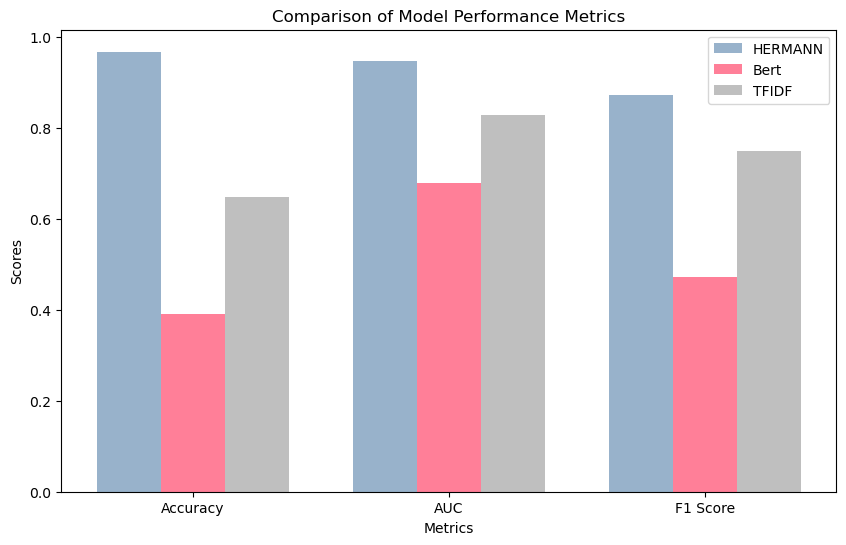

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
metrics = ['Accuracy', 'AUC', 'F1 Score']
HERMANN = [96.71/100, 0.9468, 0.8712]
Bert = [39.06/100, 0.6781, 0.4714]
TFIDF = [64.71/100, 0.8271, 0.7493]

# Set up the bar width and positions
bar_width = 0.25
index = np.arange(len(metrics))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each model's metrics with an offset for grouped bars
alpha= 0.5
color=[(0.2, 0.4, 0.6), (1, 0., 0.2),"gray"]
bar1 = ax.bar(index, HERMANN, bar_width, label='HERMANN',alpha=alpha,color=color[0])
bar2 = ax.bar(index + bar_width, Bert, bar_width, label='Bert',alpha=alpha,color=color[1])
bar3 = ax.bar(index + 2 * bar_width, TFIDF, bar_width, label='TFIDF',alpha=alpha,color=color[2])

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics)
ax.legend()

# Show plot
plt.show()
